In [1]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import os
import math
import shutil

In [2]:
ROOT_DIR = "/Brain Tumor Data Set"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

print(number_of_images.items())


dict_items([('Brain Tumor', 2513), ('Healthy', 2087)])


In [16]:
# split the data such that
# 70% for train data
# 15% for Validation
# 15%  for testing

# we will create a folder

def dataFolder(p, split):
    if not os.path.exists("/Brain Tumor Data Set" + p):
        os.mkdir("/Brain Tumor Data Set" + p)
        #   make one folder
        for dir in os.listdir(ROOT_DIR):
            os.makedirs("/Brain Tumor Data Set" + p + "/" + dir)

            for img in np.random.choice(
                    a=os.listdir(os.path.join(ROOT_DIR, dir)),
                    size=(math.floor(split * number_of_images[dir]) - 5),
                    replace=False):
                O = os.path.join(ROOT_DIR, dir, img)
                D = os.path.join("/Brain Tumor Data Set" + p, dir)
                shutil.copy(O, D)
                os.remove(O)
    #             we are copining the images to the train folder
    else:
        print("the folder exist ")

        
dataFolder("train", 0.7)
dataFolder("val", 0.15)
dataFolder("test", 0.15)

In [6]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
# Keras Conv2D is a 2D Convolution Layer, 
# this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.losses import binary_crossentropy
#  Used as a loss function for binary classification model
from keras.preprocessing.image import ImageDataGenerator
import keras
# import tensorflow as tf
# print(tf.test.gpu_device_name())
# CNN model
# convolution neural network

In [7]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
# filters numbers of filters that convolutional layers will learn from
# kernal size is height and width of the 2D convolution window
# rectified linear unit activation function
# commonly used activation function in deep learning

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
# Downsamples the input along its spatial dimensions (height and width) 
# by taking the maximum value over an input window 

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
# return 75% of my data
# Avoiding overfitting with Dropout Layer

model.add(Flatten())
# put it in 1d array
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))

model.add(Dense(units=1, activation='sigmoid'))

model.summary()
# since we are classifing the imgae if it is healthy or not so thats wy we binaryze the image
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0

In [8]:
def preprocessingImages(path):
    """
    :param path:
    :return: pre processed images
    """
    image_data = ImageDataGenerator(zoom_range=0.2, 
                                    shear_range=0.2, 
                                    rescale=1 / 255, 
                                    horizontal_flip=True)

    image = image_data.flow_from_directory(directory=path, 
                                           target_size=(224, 224), 
                                           batch_size=32, 
                                           class_mode='binary')
#The batch size defines the number of samples that will be propagated through the network.
    return image


In [9]:
def preprocessingImages2(path):
    """
    :param path:
    :return: pre processed images
    """
    image_data = ImageDataGenerator(rescale=1/255)

    image = image_data.flow_from_directory(directory=path, target_size=(224, 224), batch_size=32, class_mode='binary')

    return image


In [ ]:
path = "/Brain Tumor Data Set/train"
train_data = preprocessingImages(path)

In [98]:
# we need to generate the val images as natural as we can
# cuz we dont want ower code to run on our data set only
path = "/Brain Tumor Data Set/test"
test_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [99]:
path = "/Brain Tumor Data Set/val"
val_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [100]:
# early stopping and model check point


# early stopping
# Stop training when a monitored metric has stopped improving.
# Assuming the goal of a training is to minimize the loss.

# Early stopping is a strategy for avoiding “overtraining” your model.
# In reality, we divide our data into two sets for training machine learning models:
# the training set and the validation (or test) set.
# The first is employed for training,
# while the latter is used to evaluate how effectively the model is functioning.
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [101]:
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=5, verbose=1, mode='auto')

# model check pointCallback to save the Keras model or model weights at some frequency.
# ModelCheckpoint callback is used in conjunction with training using model.
# fit() to save a model or weights (in a checkpoint file) at some interval,
# so the model or weights can be loaded later to continue the training from the state saved.

mc = ModelCheckpoint(monitor="val_accuracy",
                     filepath="\Brain Tumor Data Set/bestmodel.h5",
                     verbose=1, 
                     save_best_only=True,
                     mode='auto')
cd = [es, mc]

In [102]:
# model train
# history
hs = model.fit_generator(generator=train_data,
                         steps_per_epoch=8,
                         epochs=30,
                         verbose=1,
                         validation_data=val_data,
                         validation_steps=16,
                         callbacks=cd)

# Epoch 00018: val_accuracy did not improve from 0.80859
# Epoch 19/30
# how we can know if the model is over fitting or not
# the diff between loss and val_loss is not  high
# the duff between accuracy and val_accuracy is not high

Epoch 1/30
8/8 [==============================] - 4s 412ms/step - loss: 0.7779 - accuracy: 0.5273 - val_loss: 0.6828 - val_accuracy: 0.5508

Epoch 00001: val_accuracy improved from -inf to 0.55078, saving model to C:/Users/fafaf\Desktop\my java folder\Brain Tumor Data Set\bestmodel.h5
Epoch 2/30
8/8 [==============================] - 3s 404ms/step - loss: 0.6695 - accuracy: 0.5820 - val_loss: 0.6303 - val_accuracy: 0.6172

Epoch 00002: val_accuracy improved from 0.55078 to 0.61719, saving model to C:/Users/fafaf\Desktop\my java folder\Brain Tumor Data Set\bestmodel.h5
Epoch 3/30
8/8 [==============================] - 3s 412ms/step - loss: 0.6643 - accuracy: 0.5977 - val_loss: 0.6156 - val_accuracy: 0.6172

Epoch 00003: val_accuracy did not improve from 0.61719
Epoch 4/30
8/8 [==============================] - 3s 421ms/step - loss: 0.6463 - accuracy: 0.5938 - val_loss: 0.6124 - val_accuracy: 0.6816

Epoch 00004: val_accuracy improved from 0.61719 to 0.68164, saving model to C:/Users/faf

In [103]:
# Model Graphical Interpretation
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<function matplotlib.pyplot.show(close=None, block=None)>

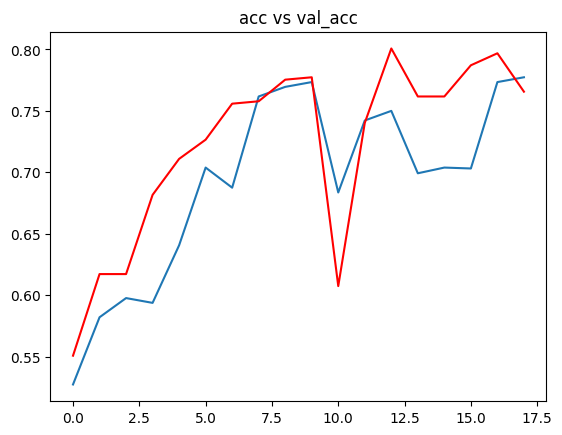

In [104]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
# val acc is performing better 
# no overfitting
plt.title("acc vs val_acc")
plt.show
# val_acc is performing better

<function matplotlib.pyplot.show(close=None, block=None)>

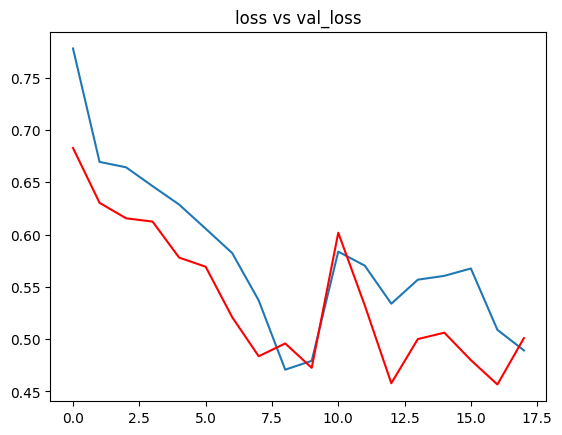

In [105]:

plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")

plt.title("loss vs val_loss")
plt.show

In [17]:
# Model Accuracy
from keras.models import load_model
model = load_model("/Brain Tumor Data Set/bestmodel.h5")

In [18]:
acc = model.evaluate_generator(test_data)[1]
# it will return the loss and the acc
print("the acc of the testing data in our model ",acc*100)

the acc of the testing data in our model  82.03240036964417


In [19]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image

In [20]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

In [49]:
def predict1(pred):
    if pred > 0.5:
        print("Healthy")
    else:
        print("Brain Tumor")

Healthy
None


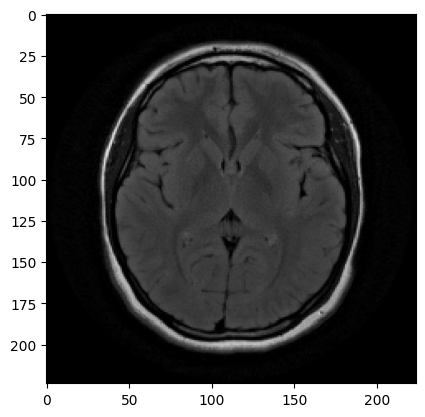

In [50]:
path = "/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (4).jpeg"
img = load_img(path,target_size= (224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show

# to transfer the var to array
input_arr = np.expand_dims(input_arr, axis= 0)
pred = model.predict(input_arr)
print(predict1(pred[0,0]))

In [51]:
def show_i(t):
    show = t.numpy()[0]
    num = show.shape[-1]
    print("filters: ", num)
    n_s = int(round(num ** 0.5, 0))
    if num ** 0.5 - n_s > 0.0:
        n_s+=1
    
    fig = plt.figure(figsize=(10,10))
    
    for n in range(num):
        
        ax = fig.add_subplot(n_s,n_s,n+1)
        ax.imshow(show[:,:, n], cmap=plt.cm.jet)
        #ax.imshow(show[:,:, n])
        plt.xticks([])
        plt.yticks([])
    plt.show()

filters:  3


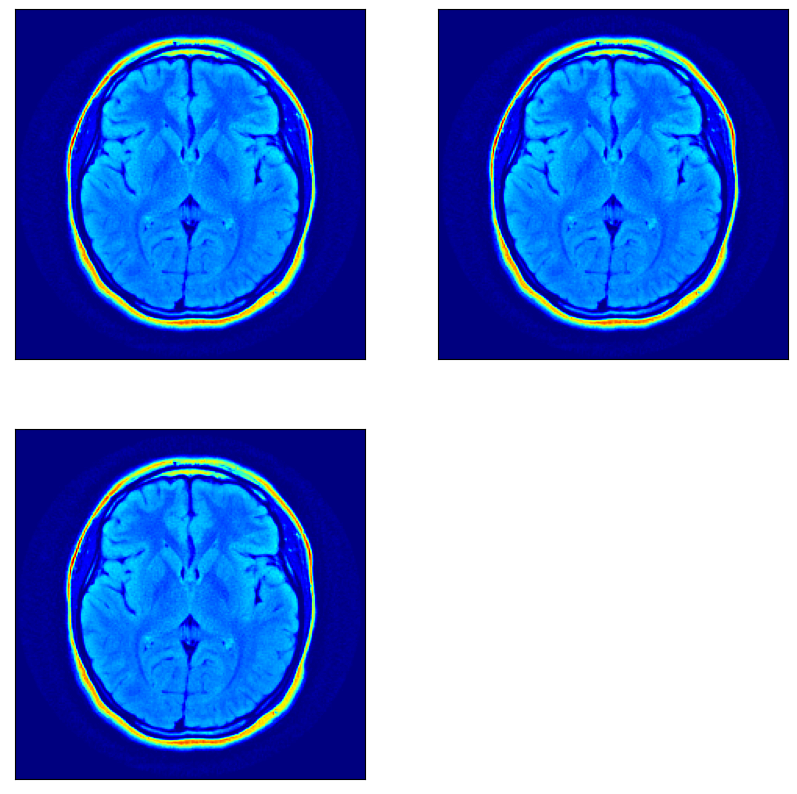

filters:  32


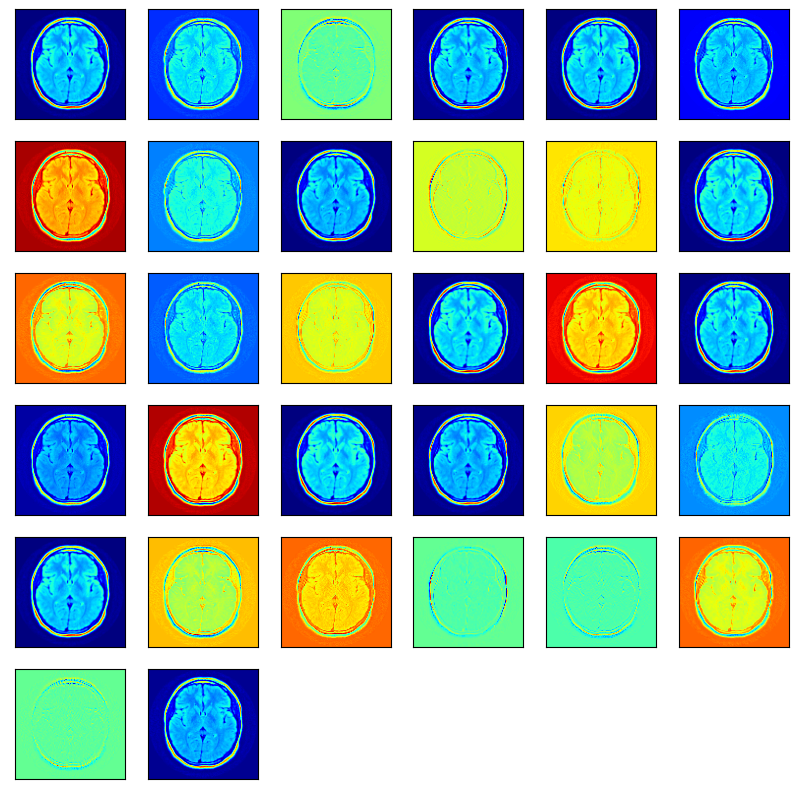

filters:  32


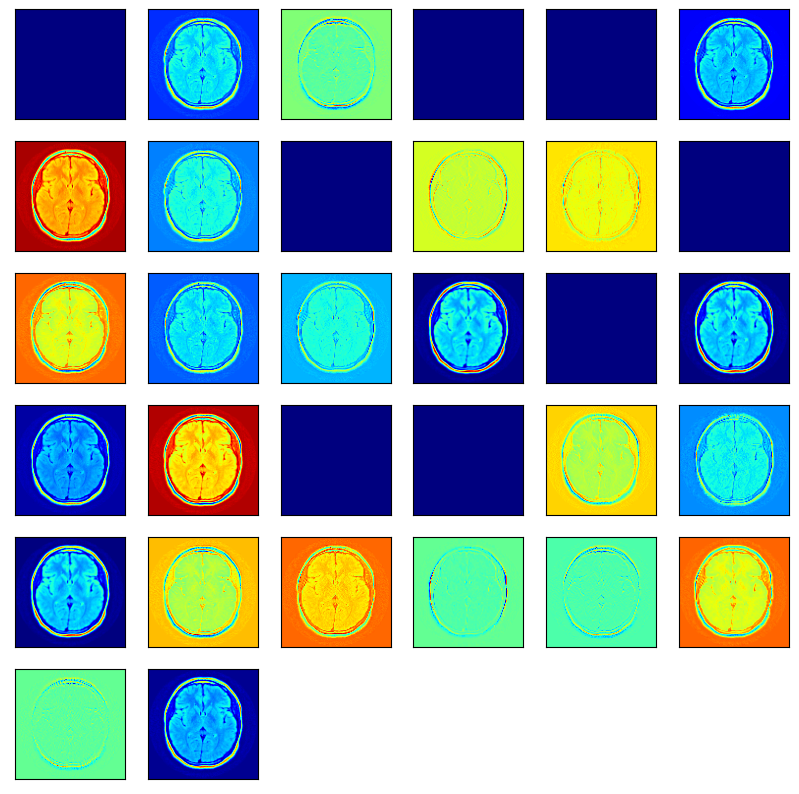

filters:  32


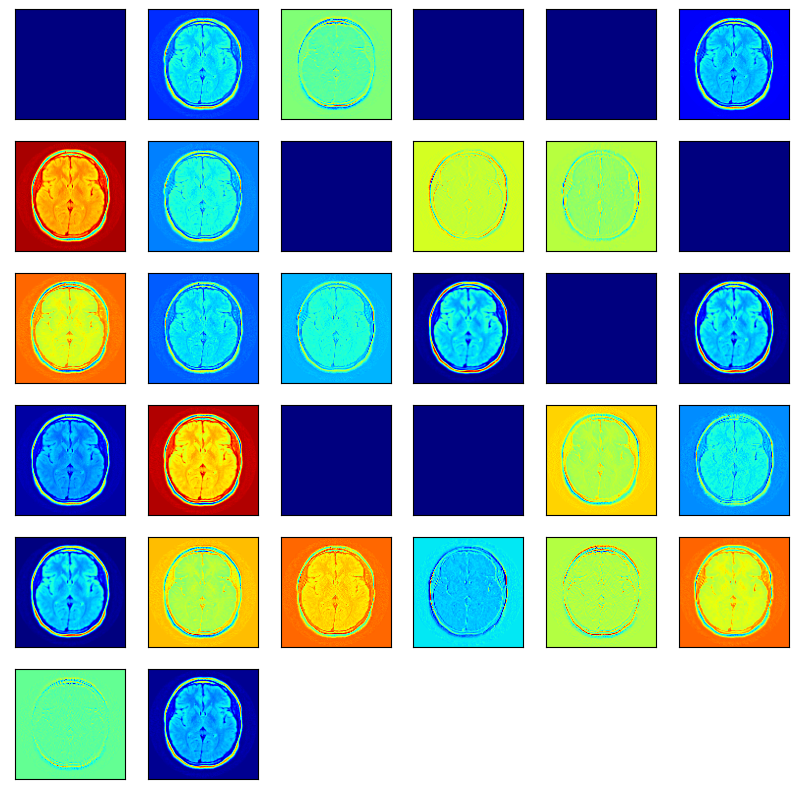

filters:  32


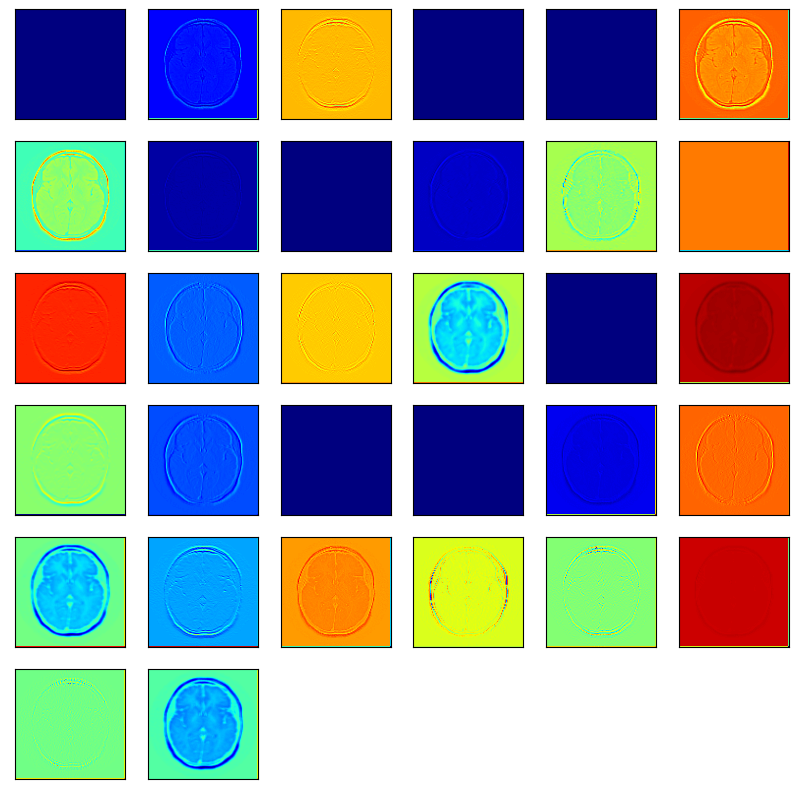

In [52]:
y = input_arr
result_list = []

n = 0

for l in model.layers[:5]:
    y = l(y)
    result_list.append(y)
    
    show_i(y)